#### load data

In [84]:
!nvidia-smi

Sat Jan  4 16:42:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:07:00.0 Off |                    0 |
| N/A   34C    P0             78W /  400W |   39298MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [85]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [86]:
!pip install matplotlib


In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [88]:
data = pd.read_csv("Project_final_data.csv")

In [89]:
data.head()

,CVE_ID,CAPEC_ID,Similarity_Score,CVE_Description,CAPEC_Description,Execution Flow
0,CVE-2023-25262,664.0,0.555823,Stimulsoft GmbH Stimulsoft Designer (Web) 2023...,An adversary exploits improper input validatio...,::STEP:1:PHASE:Explore:DESCRIPTION:[Find targe...
1,CVE-2023-46725,664.0,0.552269,FoodCoopShop is open source software for food ...,An adversary exploits improper input validatio...,::STEP:1:PHASE:Explore:DESCRIPTION:[Find targe...
2,CVE-2023-38491,209.0,0.516406,Kirby is a content management system. A vulner...,An adversary creates a file with scripting con...,::STEP:1:PHASE:Explore:DESCRIPTION:[Survey the...
3,CVE-2023-22493,664.0,0.504184,RSSHub is an open source RSS feed generator. R...,An adversary exploits improper input validatio...,::STEP:1:PHASE:Explore:DESCRIPTION:[Find targe...
4,CVE-2023-2152,219.0,0.485873,A vulnerability has been found in SourceCodest...,An attacker subverts an intermediate system us...,::STEP:1:PHASE:Explore:DESCRIPTION:[Survey the...


In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12904 entries, 0 to 12903
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CVE_ID             12904 non-null  object 
 1   CAPEC_ID           12904 non-null  float64
 2   Similarity_Score   12904 non-null  float64
 3   CVE_Description    12904 non-null  object 
 4   CAPEC_Description  12904 non-null  object 
 5   Execution Flow     12904 non-null  object 
dtypes: float64(2), object(4)
memory usage: 605.0+ KB


In [91]:
data.isnull().sum()

CVE_ID               0
CAPEC_ID             0
Similarity_Score     0
CVE_Description      0
CAPEC_Description    0
Execution Flow       0
dtype: int64

In [92]:
data.dropna(inplace=True)

In [93]:
data.isnull().sum()

CVE_ID               0
CAPEC_ID             0
Similarity_Score     0
CVE_Description      0
CAPEC_Description    0
Execution Flow       0
dtype: int64

In [94]:
df = data[['CVE_Description', 'Execution Flow']]

In [95]:
df.head()

,CVE_Description,Execution Flow
0,Stimulsoft GmbH Stimulsoft Designer (Web) 2023...,::STEP:1:PHASE:Explore:DESCRIPTION:[Find targe...
1,FoodCoopShop is open source software for food ...,::STEP:1:PHASE:Explore:DESCRIPTION:[Find targe...
2,Kirby is a content management system. A vulner...,::STEP:1:PHASE:Explore:DESCRIPTION:[Survey the...
3,RSSHub is an open source RSS feed generator. R...,::STEP:1:PHASE:Explore:DESCRIPTION:[Find targe...
4,A vulnerability has been found in SourceCodest...,::STEP:1:PHASE:Explore:DESCRIPTION:[Survey the...


In [96]:
!pip install transformers

In [97]:
!pip install torch torchvision torchaudio

In [98]:
!pip install scikit-learn

In [99]:
from transformers import T5Tokenizer
from transformers import T5ForConditionalGeneration, AdamW
import torch
from sklearn.metrics import accuracy_score

In [100]:
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [101]:
# Preprocessing Function
def preprocess_data(cve_description, execution_flow, tokenizer):
    """
    Tokenizes the CVE description and execution flow for the model.
    """
    input_text = f"generate execution flow: {cve_description}"
    input_ids = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).input_ids
    labels = tokenizer(execution_flow, return_tensors="pt", padding=True, truncation=True).input_ids
    return input_ids.squeeze(0), labels.squeeze(0)

In [102]:
# Preprocess Data from DataFrame
def preprocess_data_from_dataframe(df, tokenizer):
    """
    Preprocess input data for training from a DataFrame.
    """
    preprocessed_data = []
    for _, row in df.iterrows():
        cve_description = row['CVE_Description']
        execution_flow = row['Execution Flow']
        input_ids, labels = preprocess_data(cve_description, execution_flow, tokenizer)
        preprocessed_data.append((input_ids, labels))
    return preprocessed_data

In [103]:
# Function to calculate BLEU score
def calculate_bleu_score(predictions, references):
    """
    Calculate BLEU score for a list of predictions and references.
    """
    bleu_scores = [sentence_bleu([ref.split()], pred.split()) for ref, pred in zip(references, predictions)]
    avg_bleu = sum(bleu_scores) / len(bleu_scores) if len(bleu_scores) > 0 else 0
    return avg_bleu

def train_model_from_dataframe(model, tokenizer, df, epochs=3, batch_size=2, lr=5e-5, val_df=None):
    """
    Fine-tune the model using a DataFrame.
    """
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr)
    train_data = preprocess_data_from_dataframe(df, tokenizer)

    # For tracking loss, BLEU, and accuracy
    epoch_losses = []
    epoch_bleu_scores = []
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        total_loss = 0
        predictions = []
        references = []

        for i in range(0, len(train_data), batch_size):
            batch = train_data[i:i + batch_size]
            input_ids, labels = [], []

            for cve_desc, exec_flow in batch:
                input_ids.append(cve_desc)
                labels.append(exec_flow)

            input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True).to(model.device)
            labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True).to(model.device)

            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        avg_loss = total_loss / len(train_data)
        epoch_losses.append(avg_loss)

        # Evaluate on validation data and calculate BLEU score
        if val_df is not None:
            model.eval()
            val_predictions = []
            val_references = []
            total_val_loss = 0

            for _, row in val_df.iterrows():
                cve_description = row['Description']
                actual_execution_flow = row['Execution Flow']
                generated_flow = generate_execution_flow(model, tokenizer, cve_description)
                
                # Print actual vs generated output for debugging
                # print(f"Generated Flow: {generated_flow}")
                # print(f"Actual Execution Flow: {actual_execution_flow}")
                
                val_predictions.append(generated_flow)
                val_references.append(actual_execution_flow)

                # Calculate validation loss
                input_ids, labels = preprocess_data(cve_description, actual_execution_flow, tokenizer)
                input_ids = input_ids.unsqueeze(0).to(model.device)
                labels = labels.unsqueeze(0).to(model.device)
                outputs = model(input_ids=input_ids, labels=labels)
                val_loss = outputs.loss.item()
                total_val_loss += val_loss

            avg_val_loss = total_val_loss / len(val_df)
            avg_bleu = calculate_bleu_score(val_predictions, val_references)
            epoch_bleu_scores.append(avg_bleu)

            print(f"Validation Loss: {avg_val_loss:.4f}, Validation BLEU Score: {avg_bleu:.4f}")
        else:
            epoch_bleu_scores.append(0)  # If no validation set, append 0 BLEU score
            print(f"Validation BLEU Score: 0")

        print(f"Average Training Loss: {avg_loss:.4f}")

    return model, epoch_losses, epoch_bleu_scores

In [104]:
from tqdm import tqdm
import torch
from transformers import AdamW

def train_model_from_dataframe(model, tokenizer, df, epochs=3, batch_size=2, lr=5e-5, val_df=None):
    """
    Fine-tune the model using a DataFrame with a real-time progress bar.
    """
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr)
    train_data = preprocess_data_from_dataframe(df, tokenizer)

    # For tracking loss, BLEU, and accuracy
    epoch_losses = []
    epoch_bleu_scores = []
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        total_loss = 0
        predictions = []
        references = []

        # Create a progress bar for each epoch
        train_progress_bar = tqdm(range(0, len(train_data), batch_size), desc="Training Progress", unit="batch")

        for i in train_progress_bar:
            batch = train_data[i:i + batch_size]
            input_ids, labels = [], []

            for cve_desc, exec_flow in batch:
                input_ids.append(cve_desc)
                labels.append(exec_flow)

            input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True).to(model.device)
            labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True).to(model.device)

            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Update progress bar with the current loss
            train_progress_bar.set_postfix(loss=total_loss / (i + 1))

        avg_loss = total_loss / len(train_data)
        epoch_losses.append(avg_loss)

        # Evaluate on validation data and calculate BLEU score
        if val_df is not None:
            model.eval()
            val_predictions = []
            val_references = []
            total_val_loss = 0

            # Create a progress bar for validation
            val_progress_bar = tqdm(val_df.iterrows(), desc="Validation Progress", unit="batch", total=len(val_df))

            for _, row in val_progress_bar:
                cve_description = row['CVE_Description']
                actual_execution_flow = row['Execution Flow']
                generated_flow = generate_execution_flow(model, tokenizer, cve_description)
                
                val_predictions.append(generated_flow)
                val_references.append(actual_execution_flow)

                # Calculate validation loss
                input_ids, labels = preprocess_data(cve_description, actual_execution_flow, tokenizer)
                input_ids = input_ids.unsqueeze(0).to(model.device)
                labels = labels.unsqueeze(0).to(model.device)
                outputs = model(input_ids=input_ids, labels=labels)
                val_loss = outputs.loss.item()
                total_val_loss += val_loss

                # Update validation progress bar
                val_progress_bar.set_postfix(val_loss=total_val_loss / len(val_predictions))

            avg_val_loss = total_val_loss / len(val_df)
            avg_bleu = calculate_bleu_score(val_predictions, val_references)
            epoch_bleu_scores.append(avg_bleu)

            print(f"Validation Loss: {avg_val_loss:.4f}, Validation BLEU Score: {avg_bleu:.4f}")
        else:
            epoch_bleu_scores.append(0)  # If no validation set, append 0 BLEU score
            print(f"Validation BLEU Score: 0")

        print(f"Average Training Loss: {avg_loss:.4f}")

    return model, epoch_losses, epoch_bleu_scores


In [105]:
!pip install nltk

In [106]:
import nltk
nltk.download('punkt')  # Commonly needed for tokenization

[nltk_data] Downloading package punkt to /home/shalini/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [107]:
!pip install rouge-score


In [108]:
!pip install py-rouge


In [109]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge

In [110]:
# Function to Calculate BLEU and ROUGE Scores
# def evaluate_model_with_text_metrics(model, tokenizer, df):
#     model.eval()
#     predictions = []
#     references = []

#     for _, row in df.iterrows():
#         cve_description = row['CVE_Description']
#         actual_execution_flow = row['Execution Flow']

#         generated_flow = generate_execution_flow(model, tokenizer, cve_description)
#         predictions.append(generated_flow)
#         references.append(actual_execution_flow)

#     # Calculate BLEU Score
#     bleu_scores = [sentence_bleu([ref.split()], pred.split()) for ref, pred in zip(references, predictions)]
#     avg_bleu = sum(bleu_scores) / len(bleu_scores)

#     # Calculate ROUGE Scores
#     rouge = Rouge()
#     rouge_scores = rouge.get_scores(predictions, references, avg=True)

#     print(f"Average BLEU Score: {avg_bleu:.4f}")
#     print(f"ROUGE Scores: {rouge_scores}")

#     return avg_bleu, rouge_scores


# Function to Calculate BLEU Score
def evaluate_model_with_text_metrics(model, tokenizer, df):
    model.eval()
    predictions = []
    references = []

    for _, row in df.iterrows():
        cve_description = row['CVE_Description']
        actual_execution_flow = row['Execution Flow']

        generated_flow = generate_execution_flow(model, tokenizer, cve_description)
        predictions.append(generated_flow)
        references.append(actual_execution_flow)

    # Calculate BLEU Score
    bleu_scores = [sentence_bleu([ref.split()], pred.split()) for ref, pred in zip(references, predictions)]
    avg_bleu = sum(bleu_scores) / len(bleu_scores)

    print(f"Average BLEU Score: {avg_bleu:.4f}")

    # Return only BLEU Score
    return avg_bleu





In [111]:
# Function to plot training progress
def plot_training_progress(epoch_losses, epoch_bleu_scores):
    """
    Plot the training progress including loss and BLEU score.
    """
    epochs = range(1, len(epoch_losses) + 1)
    
    plt.figure(figsize=(10, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, epoch_losses, label='Training Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Epochs')

    # Plot BLEU Score
    plt.subplot(1, 2, 2)
    plt.plot(epochs, epoch_bleu_scores, label='Validation BLEU Score', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('BLEU Score')
    plt.title('Validation BLEU Score vs Epochs')

    plt.tight_layout()
    plt.show()

In [112]:
# Function to generate execution flow (for evaluation)
def generate_execution_flow(model, tokenizer, cve_description):
    """
    Generate the execution flow for a given CVE description.
    """
    model.eval()
    device = model.device

    input_text = f"generate execution flow for the given CVE description: {cve_description}"
    input_ids = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)

    output_ids = model.generate(
        input_ids,
        max_length=800,
        num_beams=4,
        temperature=0.7,
        top_k=50,
        early_stopping=True
    )
    execution_flow = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return execution_flow


In [113]:
# train model

In [114]:
# from transformers import T5ForConditionalGeneration, T5Tokenizer

# # Load the pre-trained T5 model and tokenizer
# tokenizer = T5Tokenizer.from_pretrained("t5-small")
# model = T5ForConditionalGeneration.from_pretrained("t5-small")

# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-small")
# model = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-small")



In [115]:
!pip install sentencepiece


In [116]:
!pip uninstall -y sentencepiece
!pip install sentencepiece


Found existing installation: sentencepiece 0.2.0
Uninstalling sentencepiece-0.2.0:
  Successfully uninstalled sentencepiece-0.2.0
  Using cached sentencepiece-0.2.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.7 kB)
Using cached sentencepiece-0.2.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)


In [117]:
import sys
print(sys.executable)


/home/shalini/kmsha_mtp/bin/python3


In [118]:
pip show transformers


Name: transformers
Version: 4.47.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /home/shalini/kmsha_mtp/lib/python3.12/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [119]:
model_name="t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

In [120]:
# Function 6: Fine-tune the Model
def fine_tune_t5_model(df, val_df, model, tokenizer, epochs=3, batch_size=2, lr=5e-5):
    """
    Fine-tune the T5 model and evaluate it.
    """

    # Train the model
    print("Starting training...")
    model, epoch_losses, epoch_bleu_scores = train_model_from_dataframe(model, tokenizer, df, epochs=epochs, batch_size=batch_size, lr=lr, val_df=val_df)

    # Plot training progress
    plot_training_progress(epoch_losses, epoch_bleu_scores)

    # Evaluate the model
    print("Evaluating model...")
    # accuracy = evaluate_model(model, tokenizer, df)
    #avg_bleu, rouge_scores = evaluate_model_with_text_metrics(model, tokenizer, df)
    avg_bleu = evaluate_model_with_text_metrics(model, tokenizer, df)

    # print(f"Average BLEU Score: {avg_bleu:.4f}")
    # print(f"ROUGE Scores: {rouge_scores}")
    
    return model

In [121]:
data = df.head(250)

In [122]:
data.shape

(250, 2)

In [123]:
from sklearn.model_selection import train_test_split

# Split your dataframe into training and validation sets (80% for training, 20% for validation)
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)

/home/shalini/kmsha_mtp/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Starting training...
Epoch 1/70


Training Progress: 100%|████████████████████████████████████████████| 100/100 [00:16<00:00,  6.06batch/s, loss=2.22]
/home/shalini/kmsha_mtp/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Validation Progress: 100%|████████████████████████████████████████| 50/50 [05:02<00:00,  6.05s/batch, val_loss=2.95]
/home/shalini/kmsha_mtp/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/shalini/kmsha_mtp/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarnin

Validation Loss: 2.9502, Validation BLEU Score: 0.0000
Average Training Loss: 2.2078
Epoch 2/70


Validation Progress: 100%|█████████████████████████████████████████████| 50/50 [07:21<00:00,  8.82s/batch, val_loss=1.69]


Validation Loss: 1.6918, Validation BLEU Score: 0.0027
Average Training Loss: 0.8994
Epoch 3/70


Validation Progress: 100%|█████████████████████████████████████████████| 50/50 [07:10<00:00,  8.61s/batch, val_loss=1.08]


Validation Loss: 1.0797, Validation BLEU Score: 0.3043
Average Training Loss: 0.4548
Epoch 4/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:56<00:00,  7.12s/batch, val_loss=0.783]


Validation Loss: 0.7835, Validation BLEU Score: 0.3831
Average Training Loss: 0.2865
Epoch 5/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [07:17<00:00,  8.74s/batch, val_loss=0.575]


Validation Loss: 0.5753, Validation BLEU Score: 0.4240
Average Training Loss: 0.1840
Epoch 6/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [08:02<00:00,  9.64s/batch, val_loss=0.452]


Validation Loss: 0.4522, Validation BLEU Score: 0.3975
Average Training Loss: 0.1122
Epoch 7/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [08:39<00:00, 10.38s/batch, val_loss=0.386]


Validation Loss: 0.3861, Validation BLEU Score: 0.4432
Average Training Loss: 0.0702
Epoch 8/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [07:52<00:00,  9.45s/batch, val_loss=0.349]


Validation Loss: 0.3485, Validation BLEU Score: 0.4288
Average Training Loss: 0.0484
Epoch 9/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [07:47<00:00,  9.35s/batch, val_loss=0.322]


Validation Loss: 0.3218, Validation BLEU Score: 0.4505
Average Training Loss: 0.0351
Epoch 10/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [07:45<00:00,  9.31s/batch, val_loss=0.306]


Validation Loss: 0.3055, Validation BLEU Score: 0.4554
Average Training Loss: 0.0276
Epoch 11/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [09:47<00:00, 11.75s/batch, val_loss=0.295]


Validation Loss: 0.2950, Validation BLEU Score: 0.3742
Average Training Loss: 0.0199
Epoch 12/70


Validation Progress: 100%|█████████████████████████████████████████████| 50/50 [07:29<00:00,  8.99s/batch, val_loss=0.27]


Validation Loss: 0.2704, Validation BLEU Score: 0.5400
Average Training Loss: 0.0147
Epoch 13/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [07:33<00:00,  9.08s/batch, val_loss=0.266]


Validation Loss: 0.2661, Validation BLEU Score: 0.4450
Average Training Loss: 0.0099
Epoch 14/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [08:28<00:00, 10.17s/batch, val_loss=0.262]


Validation Loss: 0.2620, Validation BLEU Score: 0.4236
Average Training Loss: 0.0065
Epoch 15/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [08:29<00:00, 10.19s/batch, val_loss=0.257]


Validation Loss: 0.2566, Validation BLEU Score: 0.4254
Average Training Loss: 0.0044
Epoch 16/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [08:40<00:00, 10.41s/batch, val_loss=0.257]


Validation Loss: 0.2569, Validation BLEU Score: 0.4376
Average Training Loss: 0.0033
Epoch 17/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [07:52<00:00,  9.45s/batch, val_loss=0.248]


Validation Loss: 0.2484, Validation BLEU Score: 0.4320
Average Training Loss: 0.0024
Epoch 18/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [07:36<00:00,  9.13s/batch, val_loss=0.249]


Validation Loss: 0.2487, Validation BLEU Score: 0.4848
Average Training Loss: 0.0019
Epoch 19/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [07:58<00:00,  9.58s/batch, val_loss=0.246]


Validation Loss: 0.2464, Validation BLEU Score: 0.4853
Average Training Loss: 0.0016
Epoch 20/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [08:09<00:00,  9.79s/batch, val_loss=0.246]


Validation Loss: 0.2457, Validation BLEU Score: 0.4660
Average Training Loss: 0.0014
Epoch 21/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [08:11<00:00,  9.83s/batch, val_loss=0.245]


Validation Loss: 0.2448, Validation BLEU Score: 0.4660
Average Training Loss: 0.0012
Epoch 22/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [07:56<00:00,  9.53s/batch, val_loss=0.244]


Validation Loss: 0.2444, Validation BLEU Score: 0.4662
Average Training Loss: 0.0011
Epoch 23/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [07:56<00:00,  9.52s/batch, val_loss=0.244]


Validation Loss: 0.2435, Validation BLEU Score: 0.5051
Average Training Loss: 0.0010
Epoch 24/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [07:44<00:00,  9.29s/batch, val_loss=0.243]


Validation Loss: 0.2430, Validation BLEU Score: 0.5124
Average Training Loss: 0.0009
Epoch 25/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [08:06<00:00,  9.73s/batch, val_loss=0.243]


Validation Loss: 0.2426, Validation BLEU Score: 0.4930
Average Training Loss: 0.0008
Epoch 26/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [07:41<00:00,  9.23s/batch, val_loss=0.242]


Validation Loss: 0.2422, Validation BLEU Score: 0.4930
Average Training Loss: 0.0007
Epoch 27/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [07:14<00:00,  8.70s/batch, val_loss=0.242]


Validation Loss: 0.2419, Validation BLEU Score: 0.4730
Average Training Loss: 0.0007
Epoch 28/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [06:01<00:00,  7.23s/batch, val_loss=0.242]


Validation Loss: 0.2416, Validation BLEU Score: 0.4930
Average Training Loss: 0.0006
Epoch 29/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:54<00:00,  7.08s/batch, val_loss=0.241]


Validation Loss: 0.2415, Validation BLEU Score: 0.4930
Average Training Loss: 0.0006
Epoch 30/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [06:02<00:00,  7.24s/batch, val_loss=0.241]


Validation Loss: 0.2413, Validation BLEU Score: 0.5123
Average Training Loss: 0.0005
Epoch 31/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:51<00:00,  7.04s/batch, val_loss=0.241]


Validation Loss: 0.2411, Validation BLEU Score: 0.4930
Average Training Loss: 0.0005
Epoch 32/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [06:12<00:00,  7.44s/batch, val_loss=0.241]


Validation Loss: 0.2411, Validation BLEU Score: 0.5123
Average Training Loss: 0.0005
Epoch 33/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:54<00:00,  7.09s/batch, val_loss=0.241]


Validation Loss: 0.2409, Validation BLEU Score: 0.5123
Average Training Loss: 0.0004
Epoch 34/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:52<00:00,  7.04s/batch, val_loss=0.241]


Validation Loss: 0.2410, Validation BLEU Score: 0.5323
Average Training Loss: 0.0004
Epoch 35/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [06:09<00:00,  7.38s/batch, val_loss=0.241]


Validation Loss: 0.2408, Validation BLEU Score: 0.5323
Average Training Loss: 0.0004
Epoch 36/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [06:00<00:00,  7.21s/batch, val_loss=0.241]


Validation Loss: 0.2410, Validation BLEU Score: 0.5323
Average Training Loss: 0.0004
Epoch 37/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:50<00:00,  7.01s/batch, val_loss=0.241]


Validation Loss: 0.2408, Validation BLEU Score: 0.5456
Average Training Loss: 0.0003
Epoch 38/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:54<00:00,  7.10s/batch, val_loss=0.241]


Validation Loss: 0.2411, Validation BLEU Score: 0.5321
Average Training Loss: 0.0003
Epoch 39/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:52<00:00,  7.05s/batch, val_loss=0.241]


Validation Loss: 0.2409, Validation BLEU Score: 0.5456
Average Training Loss: 0.0003
Epoch 40/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [06:05<00:00,  7.31s/batch, val_loss=0.241]


Validation Loss: 0.2412, Validation BLEU Score: 0.5321
Average Training Loss: 0.0003
Epoch 41/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:59<00:00,  7.19s/batch, val_loss=0.241]


Validation Loss: 0.2410, Validation BLEU Score: 0.5456
Average Training Loss: 0.0003
Epoch 42/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:53<00:00,  7.07s/batch, val_loss=0.241]


Validation Loss: 0.2415, Validation BLEU Score: 0.5466
Average Training Loss: 0.0003
Epoch 43/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:58<00:00,  7.17s/batch, val_loss=0.241]


Validation Loss: 0.2411, Validation BLEU Score: 0.5121
Average Training Loss: 0.0002
Epoch 44/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [06:08<00:00,  7.37s/batch, val_loss=0.242]


Validation Loss: 0.2420, Validation BLEU Score: 0.4935
Average Training Loss: 0.0003
Epoch 45/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [06:16<00:00,  7.52s/batch, val_loss=0.242]


Validation Loss: 0.2421, Validation BLEU Score: 0.5118
Average Training Loss: 0.0002
Epoch 46/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:53<00:00,  7.08s/batch, val_loss=0.243]


Validation Loss: 0.2427, Validation BLEU Score: 0.5251
Average Training Loss: 0.0003
Epoch 47/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [06:13<00:00,  7.47s/batch, val_loss=0.242]


Validation Loss: 0.2423, Validation BLEU Score: 0.5259
Average Training Loss: 0.0002
Epoch 48/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [06:21<00:00,  7.63s/batch, val_loss=0.243]


Validation Loss: 0.2432, Validation BLEU Score: 0.4943
Average Training Loss: 0.0002
Epoch 49/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [06:01<00:00,  7.24s/batch, val_loss=0.243]


Validation Loss: 0.2435, Validation BLEU Score: 0.5118
Average Training Loss: 0.0002
Epoch 50/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [06:22<00:00,  7.64s/batch, val_loss=0.246]


Validation Loss: 0.2458, Validation BLEU Score: 0.5049
Average Training Loss: 0.0003
Epoch 51/70


Validation Progress: 100%|█████████████████████████████████████████████| 50/50 [04:18<00:00,  5.17s/batch, val_loss=0.48]


Validation Loss: 0.4801, Validation BLEU Score: 0.4485
Average Training Loss: 0.0294
Epoch 52/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [06:07<00:00,  7.35s/batch, val_loss=0.283]


Validation Loss: 0.2825, Validation BLEU Score: 0.4709
Average Training Loss: 0.0522
Epoch 53/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:42<00:00,  6.86s/batch, val_loss=0.244]


Validation Loss: 0.2442, Validation BLEU Score: 0.4653
Average Training Loss: 0.0151
Epoch 54/70


Validation Progress: 100%|█████████████████████████████████████████████| 50/50 [04:31<00:00,  5.42s/batch, val_loss=0.23]


Validation Loss: 0.2298, Validation BLEU Score: 0.4886
Average Training Loss: 0.0051
Epoch 55/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:01<00:00,  6.03s/batch, val_loss=0.225]


Validation Loss: 0.2252, Validation BLEU Score: 0.5274
Average Training Loss: 0.0019
Epoch 56/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:18<00:00,  6.36s/batch, val_loss=0.224]


Validation Loss: 0.2244, Validation BLEU Score: 0.5256
Average Training Loss: 0.0009
Epoch 57/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:22<00:00,  6.45s/batch, val_loss=0.224]


Validation Loss: 0.2245, Validation BLEU Score: 0.5054
Average Training Loss: 0.0006
Epoch 58/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:15<00:00,  6.31s/batch, val_loss=0.225]


Validation Loss: 0.2248, Validation BLEU Score: 0.4882
Average Training Loss: 0.0005
Epoch 59/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:21<00:00,  6.43s/batch, val_loss=0.225]


Validation Loss: 0.2250, Validation BLEU Score: 0.4882
Average Training Loss: 0.0005
Epoch 60/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:26<00:00,  6.54s/batch, val_loss=0.225]


Validation Loss: 0.2253, Validation BLEU Score: 0.4882
Average Training Loss: 0.0004
Epoch 61/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:25<00:00,  6.51s/batch, val_loss=0.225]


Validation Loss: 0.2255, Validation BLEU Score: 0.4689
Average Training Loss: 0.0004
Epoch 62/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:33<00:00,  6.67s/batch, val_loss=0.226]


Validation Loss: 0.2256, Validation BLEU Score: 0.4689
Average Training Loss: 0.0003
Epoch 63/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:38<00:00,  6.76s/batch, val_loss=0.226]


Validation Loss: 0.2258, Validation BLEU Score: 0.4689
Average Training Loss: 0.0003
Epoch 64/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:40<00:00,  6.81s/batch, val_loss=0.226]


Validation Loss: 0.2262, Validation BLEU Score: 0.4689
Average Training Loss: 0.0003
Epoch 65/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:32<00:00,  6.66s/batch, val_loss=0.226]


Validation Loss: 0.2263, Validation BLEU Score: 0.4689
Average Training Loss: 0.0003
Epoch 66/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:32<00:00,  6.65s/batch, val_loss=0.227]


Validation Loss: 0.2266, Validation BLEU Score: 0.4689
Average Training Loss: 0.0002
Epoch 67/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:38<00:00,  6.76s/batch, val_loss=0.227]


Validation Loss: 0.2269, Validation BLEU Score: 0.4689
Average Training Loss: 0.0002
Epoch 68/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:37<00:00,  6.75s/batch, val_loss=0.227]


Validation Loss: 0.2272, Validation BLEU Score: 0.4689
Average Training Loss: 0.0002
Epoch 69/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:42<00:00,  6.84s/batch, val_loss=0.227]


Validation Loss: 0.2274, Validation BLEU Score: 0.4689
Average Training Loss: 0.0002
Epoch 70/70


Validation Progress: 100%|████████████████████████████████████████████| 50/50 [05:35<00:00,  6.71s/batch, val_loss=0.228]


Validation Loss: 0.2277, Validation BLEU Score: 0.4689
Average Training Loss: 0.0002


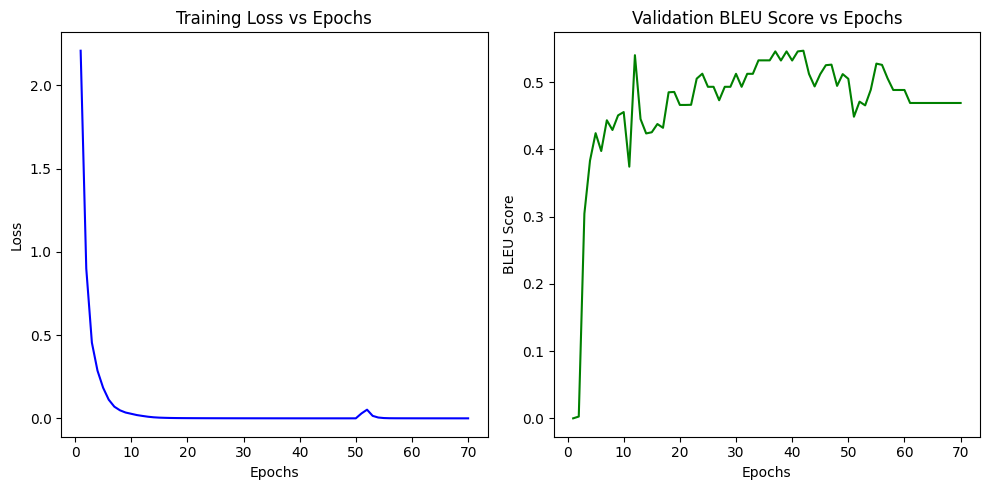

Evaluating model...
Average BLEU Score: 0.9427


In [124]:
fine_tuned_model = fine_tune_t5_model(train_df, val_df, model, tokenizer, epochs=70)

The **BLEU score** ranges from 0 to 1:<br>
1. A BLEU score of 1 means a perfect match between the generated output and reference texts.<br>
2. A BLEU score of 0 means no overlap between the generated output and reference texts.<br>

In practice, BLEU scores typically range between 0 and 1, where scores above 0.7 are generally considered good, but this can vary depending on the task and dataset.


In [125]:
# Test Prediction
new_cve_description = "A vulnerability was found in Netis Netcore Router up to 2.2.6. It has been declared as problematic. Affected by this vulnerability is an unknown functionality of the file param.file.tgz of the component Backup Handler. The manipulation leads to information disclosure. The attack can be launched remotely. The associated identifier of this vulnerability is VDB-217591."
execution_flow = generate_execution_flow(fine_tuned_model, tokenizer, new_cve_description)

print("\nGenerated Execution Flow:")
print(execution_flow)


Generated Execution Flow:
::STEP:1:PHASE:Explore:DESCRIPTION:[Survey the application for user-controllable inputs] Using a browser, an automated tool or by inspecting the application, an adversary records all entry points to the application.:TECHNIQUE:Use a spidering tool to follow and record all links and analyze the web pages to find entry points. Make special note of any links that include parameters in the URL.:TECHNIQUE:Use a proxy tool to record all user input entry points visited during a manual traversal of the web application.:TECHNIQUE:Use a browser to manually explore the website and analyze how it is constructed. Many browsers' plugins are available to facilitate the analysis or automate the discovery.:TECHNIQUE:Manually inspect the application to find entry points.::STEP:2:PHASE:Experiment:DESCRIPTION:[Probe entry points to locate vulnerabilities] The adversary uses the entry points gathered in the Explore phase as a target list and looks for areas where user input is use

In [126]:
# Assuming you have a fine-tuned model and tokenizer
fine_tuned_model = fine_tuned_model  # Replace with your fine-tuned model variable
fine_tuned_tokenizer = tokenizer  # Replace with your fine-tuned tokenizer variable

# Specify the directory to save the fine-tuned model and tokenizer
output_dir = "./T5model_with_bleu_score"

# Save the model and tokenizer
fine_tuned_model.save_pretrained(output_dir)
fine_tuned_tokenizer.save_pretrained(output_dir)

print(f"Fine-tuned model and tokenizer saved to {output_dir}")

Fine-tuned model and tokenizer saved to ./T5model_with_bleu_score


In [127]:
# Load the fine-tuned model and tokenizer
saved_model_dir = "./T5model_with_bleu_score"

# Reload the fine-tuned model and tokenizer
mo = T5ForConditionalGeneration.from_pretrained(saved_model_dir).to("cuda" if torch.cuda.is_available() else "cpu")
to = T5Tokenizer.from_pretrained(saved_model_dir)

print(f"Fine-tuned model and tokenizer loaded from {saved_model_dir}")

Fine-tuned model and tokenizer loaded from ./T5model_with_bleu_score


In [128]:
# Test Prediction
new_cve_description = "A vulnerability was found in Netis Netcore Router up to 2.2.6. It has been declared as problematic. Affected by this vulnerability is an unknown functionality of the file param.file.tgz of the component Backup Handler. The manipulation leads to information disclosure. The attack can be launched remotely. The associated identifier of this vulnerability is VDB-217591."
execution_flow = generate_execution_flow(mo, to, new_cve_description)

print("\nGenerated Execution Flow:")
print(execution_flow)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/home/shalini/kmsha_mtp/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(



Generated Execution Flow:
::STEP:1:PHASE:Explore:DESCRIPTION:[Survey the application for user-controllable inputs] Using a browser, an automated tool or by inspecting the application, an adversary records all entry points to the application.:TECHNIQUE:Use a spidering tool to follow and record all links and analyze the web pages to find entry points. Make special note of any links that include parameters in the URL.:TECHNIQUE:Use a proxy tool to record all user input entry points visited during a manual traversal of the web application.:TECHNIQUE:Use a browser to manually explore the website and analyze how it is constructed. Many browsers' plugins are available to facilitate the analysis or automate the discovery.:TECHNIQUE:Manually inspect the application to find entry points.::STEP:2:PHASE:Experiment:DESCRIPTION:[Probe entry points to locate vulnerabilities] The adversary uses the entry points gathered in the Explore phase as a target list and looks for areas where user input is use

In [129]:
# Test Prediction
new_cve_description = "A vulnerability classified as problematic was found in Supcon InPlant SCADA up to 20230901. Affected by this vulnerability is an unknown functionality of the file Project.xml. The manipulation leads to password hash with insufficient computational effort. Local access is required to approach this attack. The complexity of an attack is rather high. The exploitation appears to be difficult. The exploit has been disclosed to the public and may be used. The identifier VDB-239797 was assigned to this vulnerability. NOTE: The vendor was contacted early about this disclosure but did not respond in any way."
execution_flow = generate_execution_flow(mo, to, new_cve_description)

print("\nGenerated Execution Flow:")
print(execution_flow)


Generated Execution Flow:
::STEP:1:PHASE:Explore:DESCRIPTION:Understand the password recovery mechanism and how it works.::STEP:2:PHASE:Exploit:DESCRIPTION:Find a weakness in the password recovery mechanism and exploit it. For instance, a weakness may be that a standard single security question is used with an easy to determine answer.::


In [130]:
!nvidia-smi

Sun Jan  5 00:57:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:07:00.0 Off |                    0 |
| N/A   37C    P0            175W /  400W |   39298MiB /  40960MiB |     35%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----